In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timm
import coat
import numpy as np
import torch.nn as nn
import torch
from torchvision import datasets, models, transforms
from typing import Any
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import gc

import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Rearrange
import PIL.Image as Image
import PIL as pil

c:\Users\ML_RTC\Desktop\Tau\work\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def metric(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc

def straightner(a):
    A = np.zeros((a[0].shape[0]*len(a)))
    start_index = 0
    end_index = 0
    for i in range(len(a)):
        start_index = i*a[0].shape[0]
        end_index = start_index+a[0].shape[0]
        A[start_index:end_index] = a[i]
    return A

def predictor(outputs):
    return np.argmax(outputs, axis = 1)

c:\Users\ML_RTC\Desktop\Tau\work\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [28]:
sample = torch.rand(1,13,125,125)
sample.shape

torch.Size([1, 13, 125, 125])

In [29]:
sample = torch.nn.functional.pad(sample, (2,1,2,1))

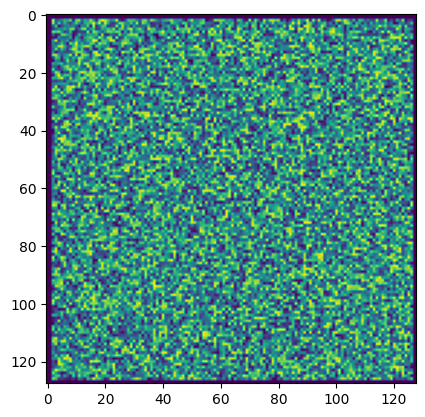

In [30]:
plt.imshow(sample[0,0,:,:])

In [27]:
import einops


class restruct(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be scaled.
        Returns:
            PIL Image or Tensor: Rescaled image.
        """
    
        return einops.rearrange(torch.squeeze(img), 'h ( w c ) -> c h w ', w = 125, c=13)


def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')


In [90]:
train_transform = transforms.Compose([transforms.Resize((128,128)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.RandomRotation(60),
                            transforms.ToTensor()
                            ])
test_transform = transforms.Compose([transforms.Resize((128,128)),
                            transforms.ToTensor()
                            ])
transform = transforms.Compose([
                             transforms.ToTensor(),
                             restruct(),
#                              transforms.Resize((128,128)),
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomVerticalFlip(),
                             transforms.RandomRotation(60),
                             
                            ]
                            )

In [91]:
# dataset_Train = datasets.ImageFolder('./data_2/Train/', transform=train_transform)
# dataset_Test = datasets.ImageFolder('./data_2/Test/', transform =test_transform)
dataset_Test = datasets.ImageFolder("C:/Users/ML_RTC/Desktop/Tau/data/Tau_Dataset/Test/",transform =transform, loader = pil_loader)
# dataloader_train = torch.utils.data.DataLoader(dataset_Train, batch_size=300, shuffle=True, drop_last = True, num_workers=4, pin_memory = True)
dataloader_test = torch.utils.data.DataLoader(dataset_Test, batch_size=300, shuffle=True, drop_last = True, num_workers=0, pin_memory = True)    


In [92]:
loader = iter(dataloader_test)

In [88]:
import time

In [93]:
a = time.time()
for i in tqdm(range(100)):
    batch = next(loader)
b = time.time()
print(b-a)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]

168.33496189117432


In [63]:
batch[0].shape

torch.Size([300, 13, 128, 128])

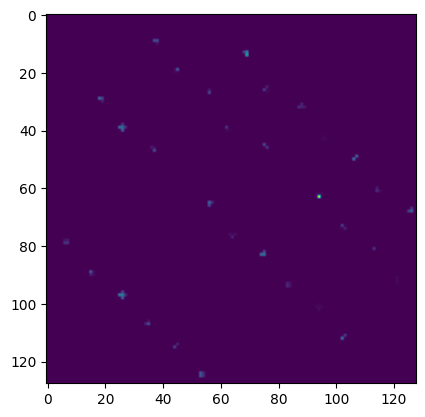

In [64]:
plt.imshow(batch[0][0,6,:,:].T)

In [ ]:














import wandb
wandb.login(key="cb53927c12bd57a0d943d2dedf7881cfcdcc8f09")
wandb.init(
    project = "Total_dataset",
    name = "CoAt-0_run2_1_low_lr_adam"
)

scaler = torch.cuda.amp.GradScaler()
#--------------------------
wandb.watch(model, log_freq=50)
#---------------------------
w_intr = 50

for epoch in range(100):
    train_loss = 0
    val_loss = 0
    train_steps = 0
    test_steps = 0
    label_list = []
    outputs_list = []
    train_auc = 0
    test_auc = 0
    model.train()
    for image, label in tqdm(dataloader_train):
        image = image.to("cuda")
        label = label.to("cuda")
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

        with torch.cuda.amp.autocast():
            outputs = model(image)
            loss = criterion(outputs, label.float())
        label_list.append(label.detach().cpu().numpy())
        outputs_list.append(outputs.detach().cpu().numpy())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        train_steps += 1
        if train_steps%w_intr == 0:
                wandb.log({"loss": loss.item()})
    with torch.no_grad():
        label_list = straightner(label_list)
        outputs_list = straightner(outputs_list)
        train_auc = metric(label_list, outputs_list) 




    #-------------------------------------------------------------------
    model.eval()
    label_list = []
    outputs_list = []
    with torch.no_grad():
        for image, label in tqdm(dataloader_test):
            image = image.to("cuda")
            label = label.to("cuda")
            outputs = model(image)
            loss = criterion(outputs, label.float())
            label_list.append(label.detach().cpu().numpy())
            outputs_list.append(outputs.detach().cpu().numpy())
            val_loss += loss.item()
            test_steps +=1
            if test_steps%w_intr == 0:
                wandb.log({"val_loss": loss.item()})
        label_list = straightner(label_list)
        outputs_list = straightner(outputs_list)
        test_auc = metric(label_list, outputs_list)

    train_loss = train_loss/train_steps
    val_loss = val_loss/ test_steps
#     hist_loss_train.append(train_loss)
#     hist_loss_test.append(val_loss)
#     hist_auc_train.append(train_auc)
#     hist_auc_test.append(test_auc)

    print("----------------------------------------------------")
    print("Epoch No" , epoch)
    print("The Training loss of the epoch, ",train_loss)
    print("The Training AUC of the epoch,  %.3f"%train_auc)
    print("The validation loss of the epoch, ",val_loss)
    print("The validation AUC of the epoch, %.3f"%test_auc)
    print("----------------------------------------------------")
    PATH = f"model_Epoch_{epoch}.pt"
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
            }, PATH)
    scheduler.step(test_auc)
    curr_lr = scheduler._last_lr[0]
    wandb.log({"Train_auc_epoch": train_auc,
                "Epoch": epoch,
                "Val_auc_epoch": test_auc,
                "Train_loss_epoch": train_loss,
                "Val_loss_epoch": val_loss,
                "Lr": curr_lr}
                )
    gc.collect()

wandb.finish()
    
    
    


In [2]:
image_size = (128,128)
in_channels = 13
num_blocks = [2, 2, 3, 5, 2]
channels = [64, 96, 192, 384, 768]
num_classes = 1
model = coat.CoAtNet(image_size = image_size,
                        in_channels = in_channels,
                        num_blocks = num_blocks,
                        channels = channels,
                        num_classes = num_classes)

c:\Users\ML_RTC\Desktop\Tau\work\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0005, weight_decay = 0.05)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose = True,threshold = 0.0001,patience = 3, factor = 0.5)
    
checkpoint = torch.load("./model_Epoch_49.pt")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler"])

model = model.to("cuda")

In [7]:
next(model.parameters())

Parameter containing:
tensor([[[[ 2.2301e-02,  1.7455e-02,  2.8985e-03],
          [-3.6400e-02, -1.3662e-02,  1.3629e-02],
          [-1.4796e-02, -3.7445e-02,  4.4692e-03]],

         [[-5.5934e-02, -5.7684e-02,  1.4471e-02],
          [ 5.6328e-03, -8.0218e-03, -1.5854e-02],
          [-4.2160e-02,  7.4119e-03, -3.2643e-02]],

         [[ 2.5006e-03,  3.7522e-02, -5.8245e-03],
          [-2.4282e-01, -3.2506e-01,  4.7450e-02],
          [ 2.8387e-02, -2.6070e-01,  3.4331e-02]],

         ...,

         [[-1.5737e-02,  8.7202e-03, -1.2302e-02],
          [ 1.1053e-02, -2.4400e-03, -2.9970e-03],
          [ 1.0037e-02, -3.8337e-03,  1.7591e-02]],

         [[ 2.3830e-02,  2.1218e-02,  9.1230e-03],
          [ 2.8399e-02,  4.5916e-02,  1.6829e-02],
          [ 5.8141e-03,  9.5554e-03,  1.0548e-02]],

         [[-4.1102e-04,  1.4738e-02,  1.2775e-02],
          [ 1.5430e-02,  2.3817e-02,  3.8250e-02],
          [-1.5172e-02,  1.1437e-03,  3.4330e-02]]],


        [[[-2.2270e-01,  1.1186

In [5]:
checkpoint

{'epoch': 49,
 'model_state_dict': OrderedDict([('s0.0.0.weight',
               tensor([[[[ 2.2301e-02,  1.7455e-02,  2.8985e-03],
                         [-3.6400e-02, -1.3662e-02,  1.3629e-02],
                         [-1.4796e-02, -3.7445e-02,  4.4692e-03]],
               
                        [[-5.5934e-02, -5.7684e-02,  1.4471e-02],
                         [ 5.6328e-03, -8.0218e-03, -1.5854e-02],
                         [-4.2160e-02,  7.4119e-03, -3.2643e-02]],
               
                        [[ 2.5006e-03,  3.7522e-02, -5.8245e-03],
                         [-2.4282e-01, -3.2506e-01,  4.7450e-02],
                         [ 2.8387e-02, -2.6070e-01,  3.4331e-02]],
               
                        ...,
               
                        [[-1.5737e-02,  8.7202e-03, -1.2302e-02],
                         [ 1.1053e-02, -2.4400e-03, -2.9970e-03],
                         [ 1.0037e-02, -3.8337e-03,  1.7591e-02]],
               
                        [[ 2.